In [1]:


from time import time
import matplotlib
#this will prevent the figure from popping up
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.elementwise import ElementwiseKernel
%matplotlib inline

In [2]:
mandel_ker = ElementwiseKernel(
"pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
"""
mandelbrot_graph[i] = 1;

pycuda::complex<float> c = lattice[i]; 
pycuda::complex<float> z(0,0);

for (int j = 0; j < max_iters; j++)
    {
    
     z = z*z + c;
     
     if(abs(z) > upper_bound)
         {
          mandelbrot_graph[i] = 0;
          break;
         }

    }
         
""",
"mandel_ker")


In [3]:
def gpu_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):

    # we set up our complex lattice as such
    real_vals = np.matrix(np.linspace(real_low, real_high, width), dtype=np.complex64)
    imag_vals = np.matrix(np.linspace( imag_high, imag_low, height), dtype=np.complex64) * 1j
    mandelbrot_lattice = np.array(real_vals + imag_vals.transpose(), dtype=np.complex64)    
    
    # copy complex lattice to the GPU
    mandelbrot_lattice_gpu = gpuarray.to_gpu(mandelbrot_lattice)

    # allocate an empty array on the GPU
    mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice.shape, dtype=np.float32)

    mandel_ker( mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound))
              
    mandelbrot_graph = mandelbrot_graph_gpu.get()
    
    return mandelbrot_graph


It took 0.0130369663239 seconds to calculate the Mandelbrot graph.
It took 0.112734079361 seconds to dump the image.


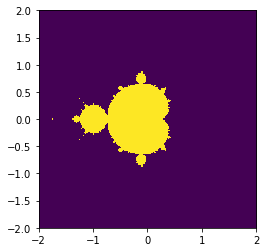

In [5]:
t1 = time()
mandel = gpu_mandelbrot(512,512,-2,2,-2,2,256, 2)
t2 = time()

mandel_time = t2 - t1

t1 = time()
fig = plt.figure(1)
plt.imshow(mandel, extent=(-2, 2, -2, 2))
plt.savefig('mandelbrot.png', dpi=fig.dpi)
t2 = time()

dump_time = t2 - t1

print 'It took {} seconds to calculate the Mandelbrot graph.'.format(mandel_time)
print 'It took {} seconds to dump the image.'.format(dump_time)
